Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from statsmodels.formula.api import ols
import statsmodels.api as sm

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from custom_functions import * #remove_extremes

Import dataset that was cleaned and prepared in Data Preparation notebook

In [2]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM step2_encoded'''
df_main = pd.read_sql(query, conn, index_col='index').reset_index(drop=True)
conn.close()

df_main.head(3)
y = 'SalePrice'

In [3]:
def remove_df_extremes(df, devct, drop_zeros=False):
    
    for col in df.columns:
        df[col] = [float(num) for num in df[col]]
        med = df[col].median()
        std = df[col].std()

        max_ = med + devct*std
        min_ = 0.0000001 if drop_zeros else med - devct*std 

        df[col] = [x if ((x>min_) & (x<max_)) else np.nan for x in df[col]]
    df.dropna(inplace=True)
    return df

In [4]:
def produce_model(df, x, y, devct, drop_zeros=False):
    model_data = pd.concat([df[y], df[x]], axis=1)
    model_data_trimmed = remove_df_extremes(model_data, devct, drop_zeros)

    formula = y + ' ~ ' + '+'.join(xs)
    
    #formula_TESTING = 'SalePrice ~ SqFtTotLiving+Bedrooms+YrBuilt+Condition+Stories'
    model = ols(formula, model_data_trimmed).fit()
    print(formula)
    
    return model, model_data_trimmed

In [5]:
def qq(df, col):
    plt.figure(figsize=(12,6));
    sm.graphics.qqplot(df[col], line='45', fit=True)
    plt.title(f'Normality Assumption Check: QQ plot of {col} values');

In [6]:
def dist(df, x):
    plt.figure(figsize=(12,6));
    sns.distplot(df[x])
    plt.title(f'Distribution of {x} (KDE)')

In [7]:
def scatter(df, x, model):
    plt.figure(figsize=(12, 6));
    sns.lmplot(data = df, x=x, y=y, line_kws={'color':'r'})    
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'Linearity Assumption: {x} vs. {y}');

In [8]:
# FUNCTION TAKEN DIRECTLY FROM FLATIRON COURSE MATERIAL (https://github.com/learn-co-curriculum/dsc-model-fit-linear-regression-lab)
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            worst_feature = pvalues.index[worst_feature] # SETH ADDED FROM ORIGINAL TO RESOLVE RUNTIME ERRORS
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [9]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18143 entries, 0 to 18142
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SalePrice            18143 non-null  int64  
 1   NbrLivingUnits       18143 non-null  int64  
 2   Stories              18143 non-null  float64
 3   BldgGrade            18143 non-null  int64  
 4   SqFtTotLiving        18143 non-null  int64  
 5   SqFtTotBasement      18143 non-null  int64  
 6   FinBasementGrade     18143 non-null  int64  
 7   SqFtGarageAttached   18143 non-null  int64  
 8   DaylightBasement     12145 non-null  float64
 9   SqFtOpenPorch        18143 non-null  int64  
 10  SqFtEnclosedPorch    18143 non-null  int64  
 11  SqFtDeck             18143 non-null  int64  
 12  HeatSystem           18143 non-null  int64  
 13  HeatSource           18143 non-null  int64  
 14  BrickStone           18143 non-null  int64  
 15  ViewUtilization      8846 non-null  

In [10]:

non_na = df_main.dropna()
X = non_na.drop(y, axis=1)
Y = non_na[y]
results = stepwise_selection(X, Y)
results

<ipython-input-8-490a43c67b3d>:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  SqFtTotLiving                  with p-value 0.0
Add  BldgGrade                      with p-value 5.33238e-153
Add  YrBuilt                        with p-value 1.34166e-234
Add  Bedrooms                       with p-value 1.52566e-48
Add  SqFtGarageAttached             with p-value 3.55739e-44
Add  SqFtOpenPorch                  with p-value 2.18649e-25
Add  Bathrooms                      with p-value 2.95929e-23
Add  ViewUtilization                with p-value 9.49855e-09
Add  forced_air_vs_other            with p-value 1.07055e-06
Add  YrRenovated                    with p-value 0.000107869
Add  HeatSystem                     with p-value 0.00115386
Add  SaleInstrument                 with p-value 0.00156042
Add  Condition                      with p-value 0.00294855
Add  HeatSource                     with p-value 0.000625013


['SqFtTotLiving',
 'BldgGrade',
 'YrBuilt',
 'Bedrooms',
 'SqFtGarageAttached',
 'SqFtOpenPorch',
 'Bathrooms',
 'ViewUtilization',
 'forced_air_vs_other',
 'YrRenovated',
 'HeatSystem',
 'SaleInstrument',
 'Condition',
 'HeatSource']

SalePrice ~ SqFtTotLiving+Bedrooms+YrBuilt+Condition+Stories+forced_air_vs_other+BldgGrade


<Figure size 864x432 with 0 Axes>

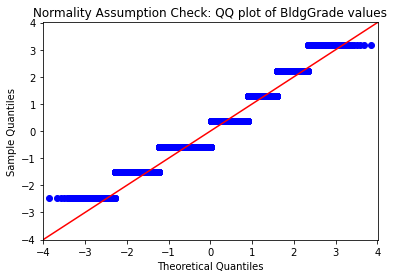

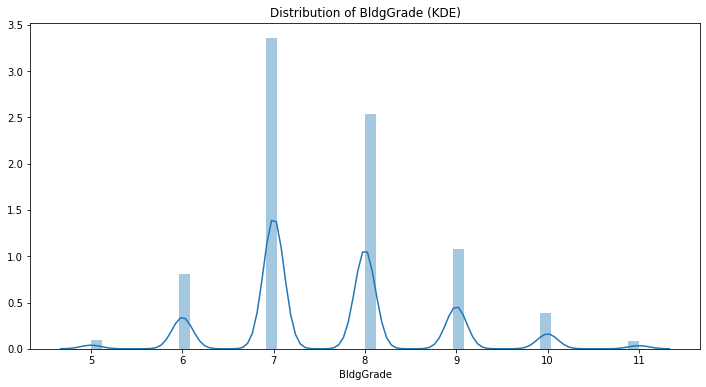

<Figure size 864x432 with 0 Axes>

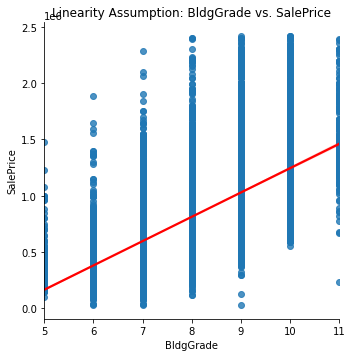

In [11]:
xs = ['SqFtTotLiving', 'Bedrooms', 'YrBuilt', 'Condition', 'Stories', 'forced_air_vs_other', 'BldgGrade']


model, df_trimmed = produce_model(df_main, xs, y, 3)
model.summary()

# fig = plt.figure(figsize=(15,8))
# fig = sm.graphics.plot_regress_exog(model, 'YrBuilt', fig=fig)
# plt.show()


x = 'BldgGrade'
qq(df_trimmed, x);
dist(df_trimmed, x)
scatter(df_trimmed, x, model)

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     2792.
Date:                Sat, 06 Mar 2021   Prob (F-statistic):               0.00
Time:                        20:47:38   Log-Likelihood:            -2.4059e+05
No. Observations:               17368   AIC:                         4.812e+05
Df Residuals:                   17360   BIC:                         4.812e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            6.897e+06   1.55e+05     44.428      0.000    6.59e+06     7.2e+06
SqFtTotLiving         173.4736      4.068     42.642      0.000     165.500     181.448
Bedrooms             -3.57e+04   2994.819    -11.922      0.000   -4.16e+04   -2.98e+04
YrBuilt             -3964.7981     80.642    -49.165      0.000   -4122.865   -3806.731
Condition            1.213e+04   2991.257      4.054      0.000    6262.607     1.8e+04
Stories              5.895e+04   4582.154     12.865      0.000       5e+04    6.79e+04
forced_air_vs_other -5.473e+04   4729.470    -11.571      0.000    -6.4e+04   -4.55e+04
BldgGrade            1.755e+05   2856.004     61.451      0.000     1.7e+05    1.81e+05
==============================================================================
Omnibus:                     3326.514   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10720.094
Skew:                           0.974   Prob(JB):                         0.00
Kurtosis:                       6.319   Cond. No.                     2.37e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

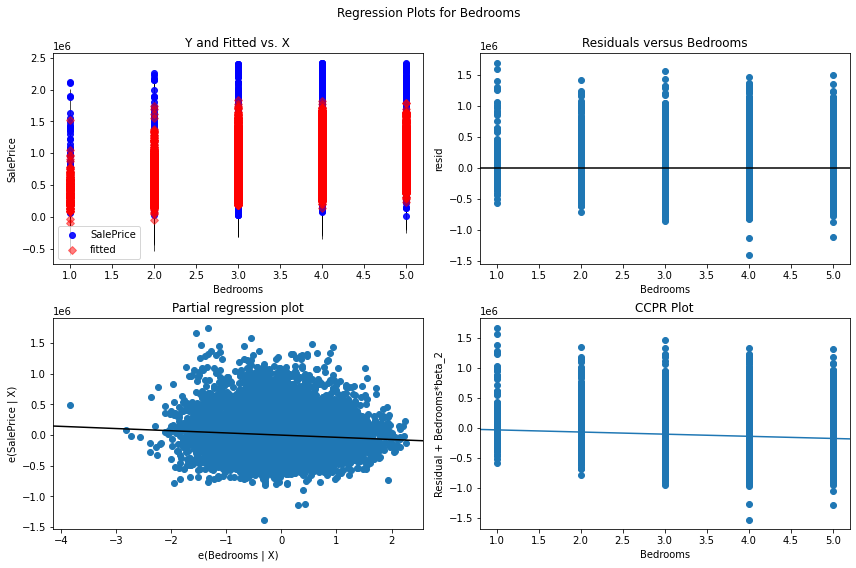

In [13]:
sm.graphics.plot_regress_exog(model, 'Bedrooms', fig=plt.figure(figsize=(12, 8)));

In [14]:
df_main.columns

Index(['SalePrice', 'NbrLivingUnits', 'Stories', 'BldgGrade', 'SqFtTotLiving',
       'SqFtTotBasement', 'FinBasementGrade', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'YrBuilt', 'YrRenovated', 'Condition', 'SaleInstrument',
       'forced_air_vs_other', 'SqFtUnfinished', 'Bathrooms', 'Fireplaces'],
      dtype='object')

Text(0.5, 1.0, 'Correlation Matrix for Remaining Features')

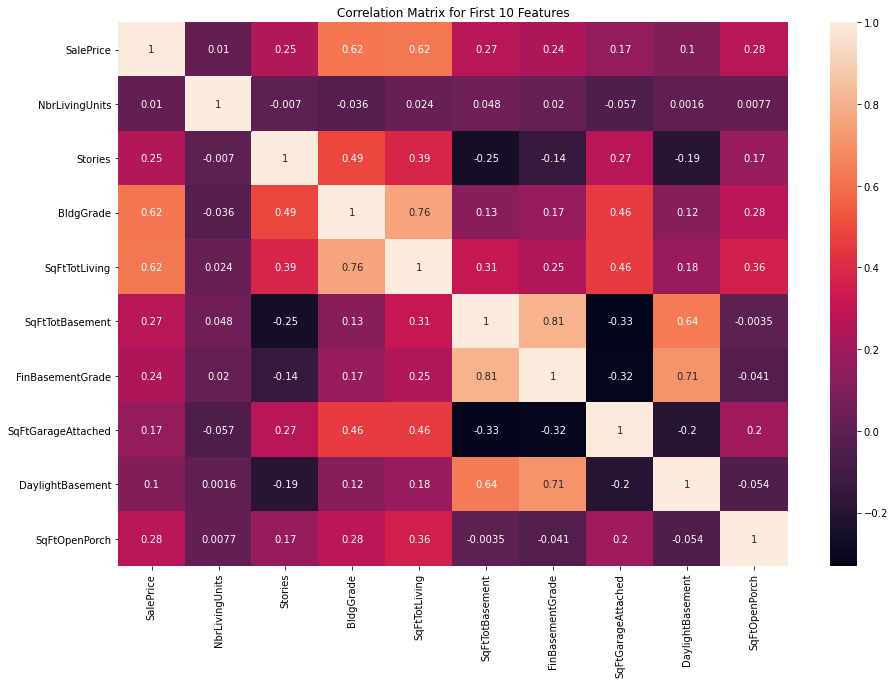

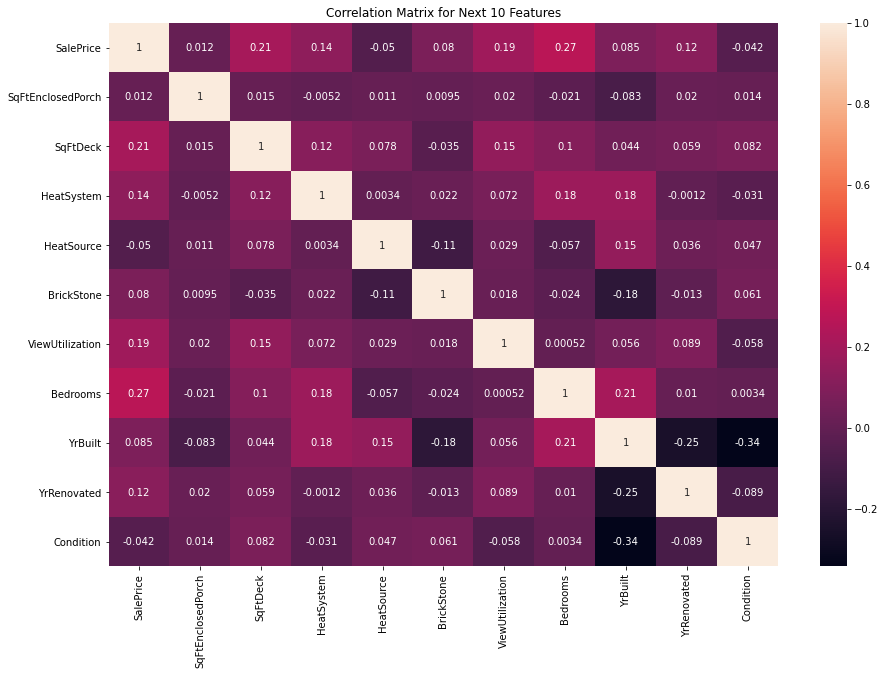

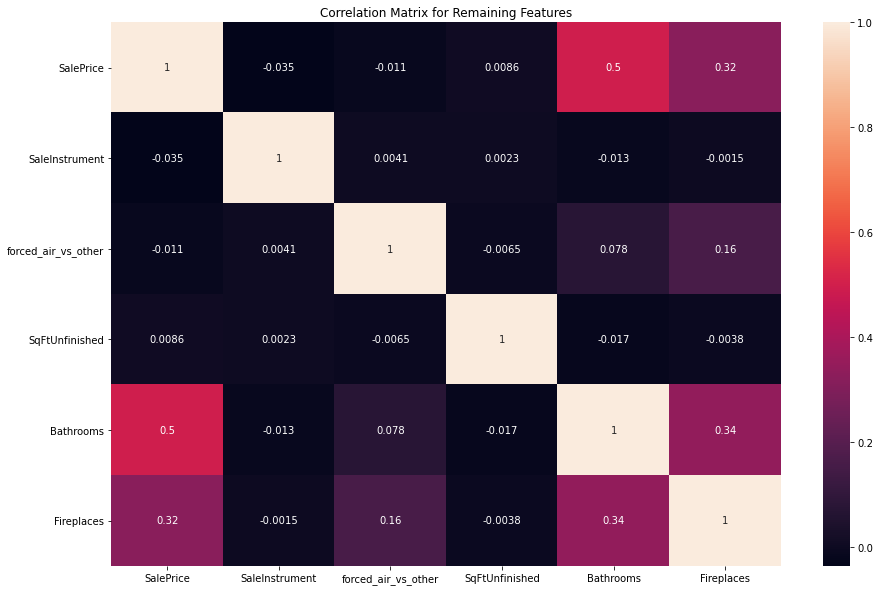

In [15]:
#all_data = pd.concat([df_main[y], df_main[xs]], axis=1)
CorrMatrix = df_main.corr()


CorrMatrix = df_main.iloc[:, :10].corr()
plt.figure(figsize=(15,10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for First 10 Features');

CorrMatrix = pd.concat([df_main[y], df_main.iloc[:, 10:20]], axis=1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for Next 10 Features')

CorrMatrix = pd.concat([df_main[y], df_main.iloc[:, 20:]], axis=1).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(CorrMatrix, annot=True)
plt.title('Correlation Matrix for Remaining Features')

In [16]:
correlations = df_main.corr().stack().reset_index()
correlations = correlations.loc[(correlations.level_0 == 'SalePrice') & (correlations.level_1 != 'SalePrice')]
correlations[0] = correlations[0].abs()
correlations.columns = ['Dependent', 'Feature', 'Correlation (abs)']

correlations.sort_values(by='Correlation (abs)', ascending=False, inplace=True)
correlations.reset_index(inplace=True, drop=True)
listed = list(correlations.loc[correlations['Correlation (abs)'] > 0.1].Feature.values)

df_main[listed].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18143 entries, 0 to 18142
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SqFtTotLiving       18143 non-null  int64  
 1   BldgGrade           18143 non-null  int64  
 2   Bathrooms           18143 non-null  float64
 3   Fireplaces          18143 non-null  int64  
 4   SqFtOpenPorch       18143 non-null  int64  
 5   Bedrooms            18143 non-null  int64  
 6   SqFtTotBasement     18143 non-null  int64  
 7   Stories             18143 non-null  float64
 8   FinBasementGrade    18143 non-null  int64  
 9   SqFtDeck            18143 non-null  int64  
 10  ViewUtilization     8846 non-null   float64
 11  SqFtGarageAttached  18143 non-null  int64  
 12  HeatSystem          18143 non-null  int64  
 13  YrRenovated         18143 non-null  int64  
 14  DaylightBasement    12145 non-null  float64
dtypes: float64(4), int64(11)
memory usage: 2.1 MB
